# AI Powered Sales Forecasting


**Importing the modules**
* Loading the dataset [Superstore-dataset]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

#Loading dataset
data=pd.read_csv('/kaggle/input/superstore-dataset-final/Sample - Superstore.csv', encoding='latin1')



**Data Cleaning** 
* parsing the date
* dropping duplicate records
* dropping missing values 

In [2]:
#parsing the date 
data["Order Date"] = pd.to_datetime(data["Order Date"])
data["Ship Date"] = pd.to_datetime(data["Ship Date"])

#Dropping the duplicates
data.drop_duplicates(inplace=True)

#dropping missing values
data=data.dropna(subset=['Order Date','Profit','Sales'])

**Feature Engineering**
* Obtaining Delivery days from Order Date and Ship Date
* Monthly Sales Aggregation

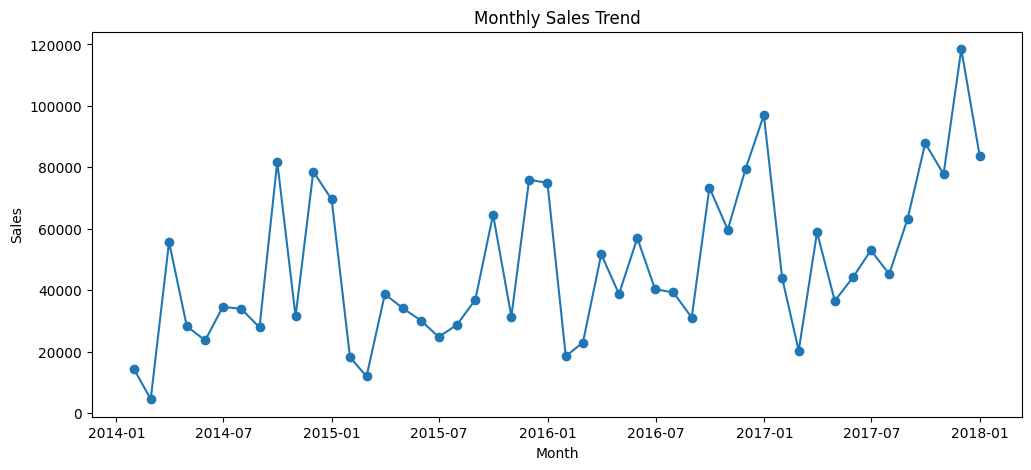

In [3]:
#obtaining Delivery Days
data['Delivery Days']=(data['Ship Date']-data['Order Date']).dt.days

#Monthly sales aggregation
monthly_sales = data.groupby(pd.Grouper(key="Order Date", freq="ME"))["Sales"].sum().reset_index()
monthly_sales = monthly_sales.rename(columns={"Order Date": "ds", "Sales": "y"})

#plotting monthly sales
plt.figure(figsize=(12,5))
plt.plot(monthly_sales["ds"], monthly_sales["y"], marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

**Calculating Monthly and Yearly Comparision**

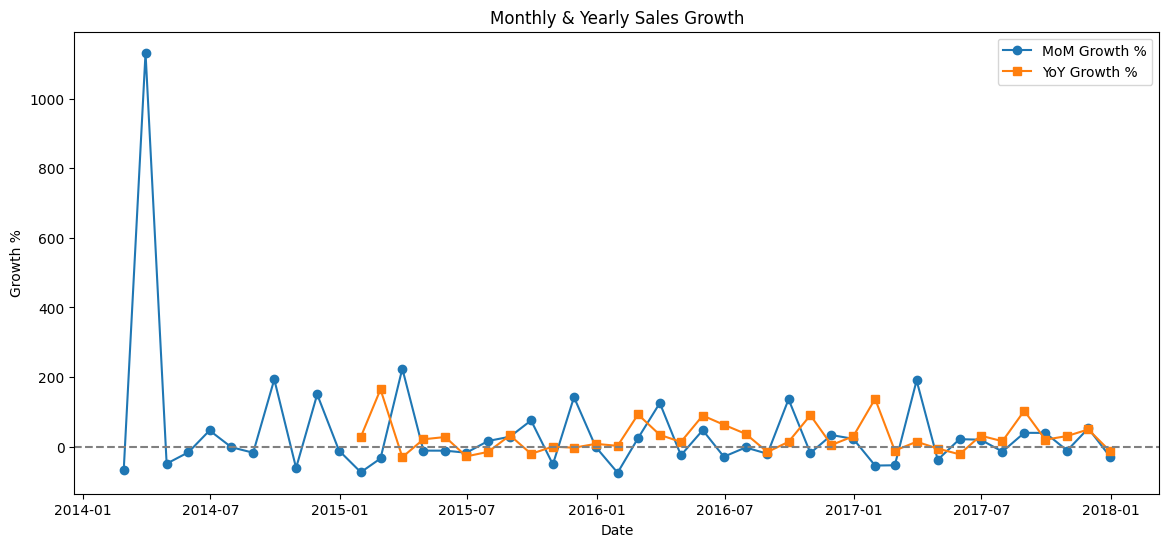

In [4]:
# Extract Year & Month
monthly_sales["Year"] = monthly_sales["ds"].dt.year
monthly_sales["Month"] = monthly_sales["ds"].dt.month

# Month-over-Month Growth
monthly_sales["MoM Growth %"] = monthly_sales["y"].pct_change() * 100

# Year-over-Year Growth
monthly_sales["YoY Growth %"] = monthly_sales.groupby("Month")["y"].pct_change() * 100


# Plot MoM and YoY Growth
plt.figure(figsize=(14,6))
plt.plot(monthly_sales["ds"], monthly_sales["MoM Growth %"], label="MoM Growth %", marker="o")
plt.plot(monthly_sales["ds"], monthly_sales["YoY Growth %"], label="YoY Growth %", marker="s")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Monthly & Yearly Sales Growth")
plt.xlabel("Date")
plt.ylabel("Growth %")
plt.legend()
plt.show()



**Insight Cards(for Power BI)**

In [5]:
# Total Sales
total_sales = data["Sales"].sum()

# Total Profit
total_profit = data["Profit"].sum()

# Avg Delivery Days
avg_delivery_days = data["Delivery Days"].mean()

# YoY Growth (latest year vs previous year)
latest_year = monthly_sales["Year"].max()
prev_year = latest_year - 1

sales_latest_year = monthly_sales.loc[monthly_sales["Year"]==latest_year, "y"].sum()
sales_prev_year = monthly_sales.loc[monthly_sales["Year"]==prev_year, "y"].sum()
yoy_growth = ((sales_latest_year - sales_prev_year) / sales_prev_year) * 100

# Top Category
top_category = data.groupby("Category")["Sales"].sum().idxmax()

# Export KPIs for Power BI
kpis = pd.DataFrame({
    "Metric": ["Total Sales","Total Profit","Avg Delivery Days","YoY Growth %","Top Category"],
    "Value": [total_sales, total_profit, avg_delivery_days, yoy_growth, top_category]
})
kpis.to_csv("insight_cards.csv", index=False)


**Filter By Category/Store/Region**

In [6]:
# Category-level sales over time
category_sales = data.groupby([pd.Grouper(key="Order Date", freq="ME"), "Category"])["Sales"].sum().reset_index()

# Region-level sales over time
region_sales = data.groupby([pd.Grouper(key="Order Date", freq="ME"), "Region"])["Sales"].sum().reset_index()

# Store/Customer Segment-level sales
segment_sales = data.groupby([pd.Grouper(key="Order Date", freq="ME"), "Segment"])["Sales"].sum().reset_index()

# Save for Power BI
category_sales.to_csv("category_sales.csv", index=False)
region_sales.to_csv("region_sales.csv", index=False)
segment_sales.to_csv("segment_sales.csv", index=False)



**Top Selling products and Low seasons**

In [7]:
# Top-selling items (Sub-Category)
subcat_sales = data.groupby("Sub-Category")["Sales"].sum().reset_index().sort_values(by="Sales", ascending=False)

print("Top 5 Sub-Categories:\n", subcat_sales.head())
print("\nLowest 5 Sub-Categories:\n", subcat_sales.tail())

# Identify low seasons (monthly avg sales by month number)
monthly_pattern = data.groupby(data["Order Date"].dt.month)["Sales"].mean().reset_index()
monthly_pattern.columns = ["Month", "Avg_Sales"]

print("\nSeasonality (Low demand months):\n", monthly_pattern.sort_values(by="Avg_Sales").head())


Top 5 Sub-Categories:
    Sub-Category       Sales
13       Phones  330007.054
5        Chairs  328449.103
14      Storage  223843.608
16       Tables  206965.532
3       Binders  203412.733

Lowest 5 Sub-Categories:
    Sub-Category      Sales
15     Supplies  46673.538
2           Art  27118.792
7     Envelopes  16476.402
10       Labels  12486.312
8     Fasteners   3024.280

Seasonality (Low demand months):
    Month   Avg_Sales
1      2  199.170838
3      4  206.230731
6      7  207.377601
4      5  210.923553
5      6  212.996763


**Prophet Model Forecast**

/usr/local/lib/python3.11/dist-packages/holidays/countries/india.py:182: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing


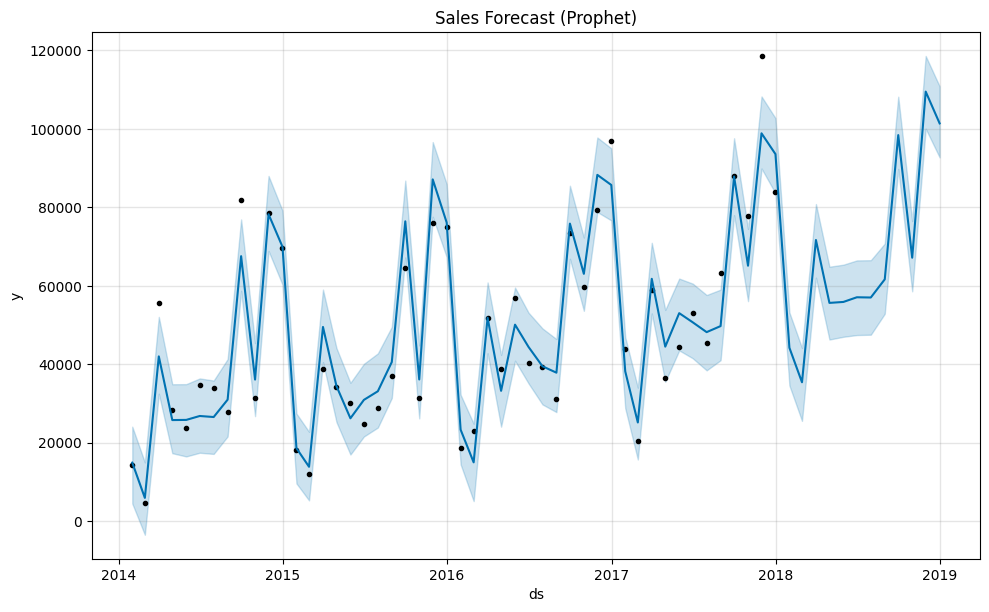

In [8]:
#Initializing Prophet Model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.add_country_holidays(country_name='India')
prophet_model.fit(monthly_sales)

# Forecast next 12 months
future = prophet_model.make_future_dataframe(periods=12, freq="ME")
forecast = prophet_model.predict(future)

# Plot
fig1 = prophet_model.plot(forecast)
plt.title("Sales Forecast (Prophet)")
plt.show()

**SARIMAX Forecast**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


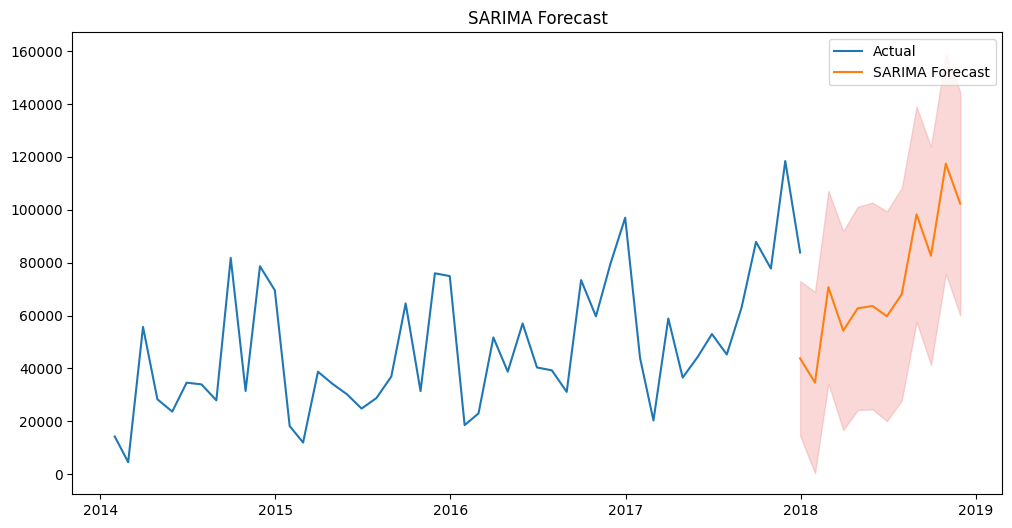

In [9]:
# SARIMA model on monthly sales
sarima_model = SARIMAX(monthly_sales["y"], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)

# Forecast next 12 months
sarima_forecast = sarima_fit.get_forecast(steps=12)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Plot SARIMA vs Actual
plt.figure(figsize=(12,6))
plt.plot(monthly_sales["ds"], monthly_sales["y"], label="Actual")
plt.plot(pd.date_range(monthly_sales["ds"].iloc[-1], periods=12, freq="ME"), sarima_pred, label="SARIMA Forecast")
plt.fill_between(pd.date_range(monthly_sales["ds"].iloc[-1], periods=12, freq="ME"),
                 sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color="lightcoral", alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast")
plt.show()

**XGBoost Forecasing**

XGBoost RMSE: 14996.40, MAE: 11896.28


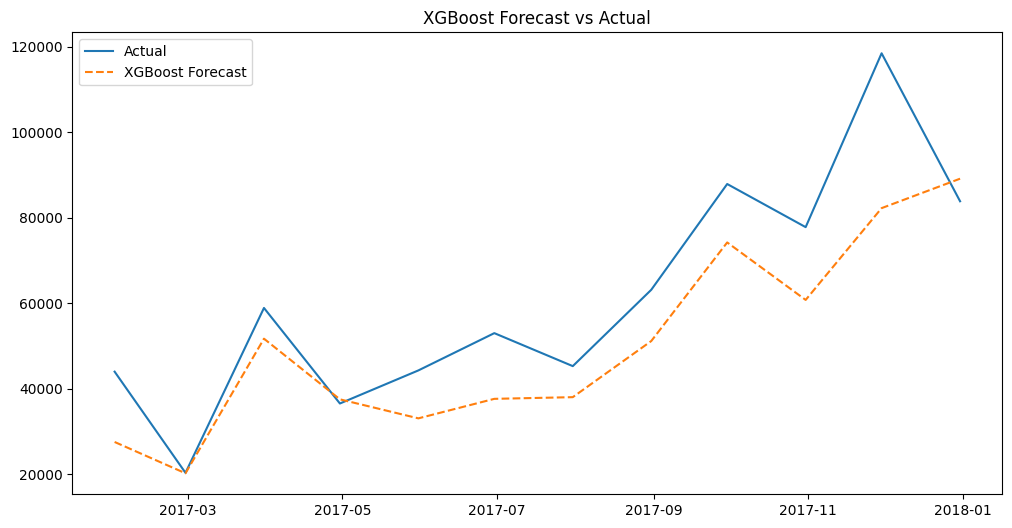

In [10]:
# Create lag features
lag_data = monthly_sales.copy()
lag_data["lag1"] = lag_data["y"].shift(1)
lag_data["lag12"] = lag_data["y"].shift(12)
lag_data = lag_data.dropna()

# Train-test split (last 12 months as test)
train = lag_data[:-12]
test = lag_data[-12:]

X_train = train[["lag1","lag12"]]
y_train = train["y"]
X_test = test[["lag1","lag12"]]
y_test = test["y"]

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
mae = mean_absolute_error(y_test, xgb_preds)
print(f"XGBoost RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(test["ds"], y_test, label="Actual")
plt.plot(test["ds"], xgb_preds, label="XGBoost Forecast", linestyle="--")
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.show()


**Ensembling All three Model into Single Forecast**

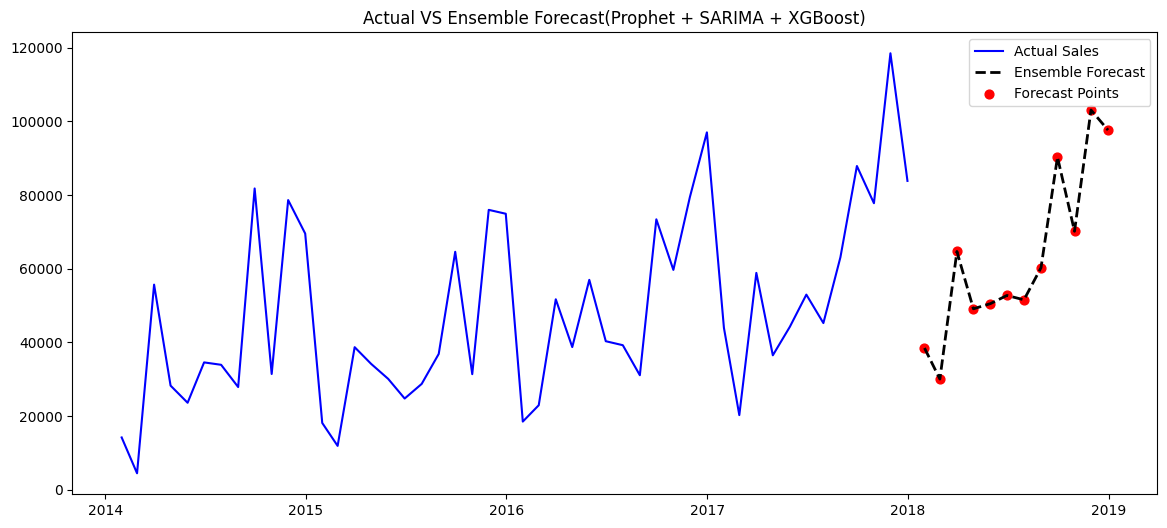

In [11]:
# last date in the actual dataset
last_date = monthly_sales["ds"].max()

# common 12-month future index
future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq="ME")

# Prophet forecast
prophet_fc = forecast[["ds","yhat"]].set_index("ds").reindex(future_dates)
prophet_fc.rename(columns={"yhat":"prophet_yhat"}, inplace=True)

# SARIMA forecast 
sarima_fc = sarima_pred.to_frame(name="sarima_yhat")
sarima_fc.index = future_dates 

# XGBoost forecast 
xgb_fc = pd.DataFrame({"ds": future_dates, "xgb_yhat": xgb_preds}).set_index("ds")

# Merge forecasts
ensemble_df = prophet_fc.join(sarima_fc).join(xgb_fc)
ensemble_df["ensemble_yhat"] = ensemble_df.mean(axis=1)

# --- Build Actual vs Ensemble dataset ---
actual_df = monthly_sales[["ds","y"]].copy()
actual_df["Type"] = "Actual"

forecast_df = ensemble_df.reset_index().rename(columns={"index":"ds"})
forecast_df = forecast_df[["ds","ensemble_yhat"]].rename(columns={"ensemble_yhat":"y"})
forecast_df["Type"] = "Forecast"

# Combine
final_df = pd.concat([actual_df, forecast_df], ignore_index=True)

# Save to CSV for Power BI
final_df.to_csv("actual_vs_ensemble.csv", index=False)

# Plot ensemble vs actual
plt.figure(figsize=(14,6))
plt.plot(monthly_sales["ds"], monthly_sales["y"], label="Actual Sales", color="blue")
plt.plot(ensemble_df.index, ensemble_df["ensemble_yhat"], 
         label="Ensemble Forecast", linestyle="--", color="black", linewidth=2)
plt.scatter(ensemble_df.index, ensemble_df["ensemble_yhat"], 
            color="red", s=40, label="Forecast Points")
plt.legend()
plt.title("Actual VS Ensemble Forecast(Prophet + SARIMA + XGBoost)")
plt.show()